In [288]:
# !pip install opendatasets
# import opendatasets as od
# od.download("https://www.kaggle.com/competitions/cpe-ai-openhouse-loan-approval-prediction/overview")

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [290]:
train_df = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/train.csv')
final_df = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/test.csv')

In [291]:
train_df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [292]:
train_df = train_df.rename(columns={
    'person_age': 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'lo_income',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred',
    'loan_status' : 'status'
})

final_df = final_df.rename(columns={
    'person_age': 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'lo_income',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred',
})

In [293]:
id_final = final_df.id
final_df = final_df.drop(columns=['id'])
train_df = train_df.drop(columns=['id'])

In [294]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31640 entries, 0 to 31639
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        30772 non-null  float64
 1   income     30786 non-null  float64
 2   home       30766 non-null  object 
 3   emp        30804 non-null  float64
 4   intent     30792 non-null  object 
 5   gra        30776 non-null  object 
 6   amnt       30770 non-null  float64
 7   rate       30789 non-null  float64
 8   lo_income  30770 non-null  float64
 9   file       30776 non-null  object 
 10  cred       30766 non-null  float64
 11  status     31640 non-null  int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 2.9+ MB


In [295]:
train_df = pd.get_dummies(train_df, columns=['home', 'intent', 'gra', 'file'], dtype=int)
final_df = pd.get_dummies(final_df, columns=['home', 'intent', 'gra', 'file'], dtype=int)

In [296]:
train_df = train_df.fillna(train_df.median())
final_df = final_df.fillna(final_df.median())

norm_train = MinMaxScaler().fit_transform(train_df)
norm_final = MinMaxScaler().fit_transform(final_df)
train_df = pd.DataFrame(norm_train, columns=train_df.columns)
final_df = pd.DataFrame(norm_final, columns=final_df.columns)

<Axes: >

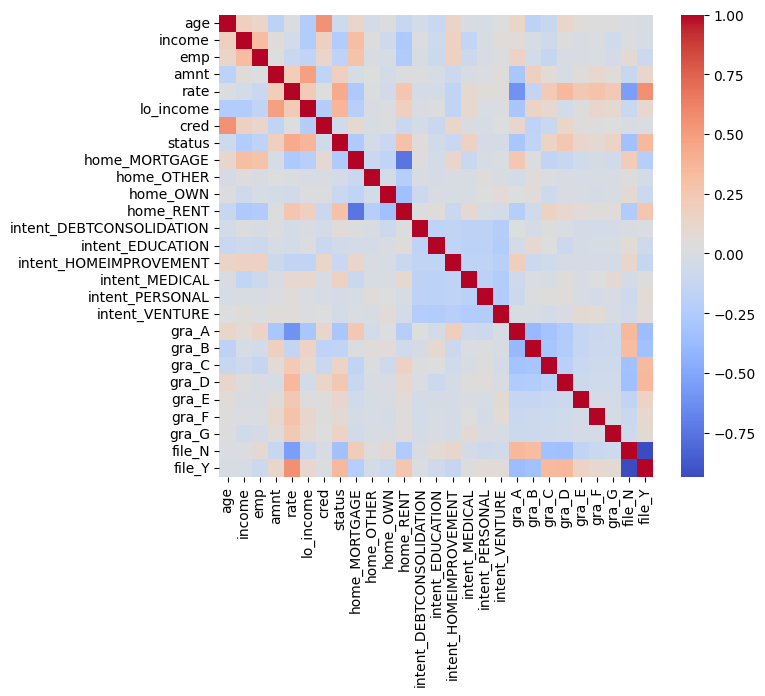

In [297]:
cor = train_df.corr()
plt.figure(figsize=(7,6))
sns.heatmap(cor, annot=False, cmap='coolwarm')

In [298]:
values, counts = np.unique(train_df.status, return_counts=True)
values, counts

(array([0., 1.]), array([23598,  8042]))

In [299]:
y_train_df = train_df.status
train_df = train_df.drop(columns=['status'])

In [300]:
x_train, x_val, y_train, y_val = train_test_split(train_df, y_train_df, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [301]:
x_train = x_train.values.astype(np.float32)
y_train = y_train.values.astype(np.float32).reshape(-1, 1)
tensor_y_train = torch.tensor(y_train)

x_val = x_val.values.astype(np.float32)
y_val = y_val.values.astype(np.float32).reshape(-1, 1)
tensor_y_val = torch.tensor(y_val)

x_test = x_test.values.astype(np.float32)
y_test = y_test.values.astype(np.float32).reshape(-1, 1)
tensor_y_test = torch.tensor(y_test)

x_final = final_df.values.astype(np.float32)

In [302]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31640 entries, 0 to 31639
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       31640 non-null  float64
 1   income                    31640 non-null  float64
 2   emp                       31640 non-null  float64
 3   amnt                      31640 non-null  float64
 4   rate                      31640 non-null  float64
 5   lo_income                 31640 non-null  float64
 6   cred                      31640 non-null  float64
 7   home_MORTGAGE             31640 non-null  float64
 8   home_OTHER                31640 non-null  float64
 9   home_OWN                  31640 non-null  float64
 10  home_RENT                 31640 non-null  float64
 11  intent_DEBTCONSOLIDATION  31640 non-null  float64
 12  intent_EDUCATION          31640 non-null  float64
 13  intent_HOMEIMPROVEMENT    31640 non-null  float64
 14  intent

In [303]:
# num
x_num_train = torch.tensor(x_train[:, :7])
x_num_val = torch.tensor(x_val[:, :7])
x_num_test = torch.tensor(x_test[:, :7])
x_num_final = torch.tensor(x_final[:, :7])

# categorical
x_home_train = torch.tensor(x_train[:, 7:11])
x_home_val = torch.tensor(x_val[:, 7:11])
x_home_test = torch.tensor(x_test[:, 7:11])
x_home_final = torch.tensor(x_final[:, 7:11])

x_intent_train = torch.tensor(x_train[:, 11:17])
x_intent_val = torch.tensor(x_val[:, 11:17])
x_intent_test = torch.tensor(x_test[:, 11:17])
x_intent_final = torch.tensor(x_final[:, 11:17])

x_gra_train = torch.tensor(x_train[:, 17:24])
x_gra_val = torch.tensor(x_val[:, 17:24])
x_gra_test = torch.tensor(x_test[:, 17:24])
x_gra_final = torch.tensor(x_final[:, 17:24])

x_file_train = torch.tensor(x_train[:, 24:26])
x_file_val = torch.tensor(x_val[:, 24:26])
x_file_test = torch.tensor(x_test[:, 24:26])
x_file_final = torch.tensor(x_final[:, 24:26])

x_cate_trian = [x_home_train, x_intent_train, x_gra_train, x_file_train]
x_cate_val = [x_home_val, x_intent_val, x_gra_val, x_file_val]
x_cate_test = [x_home_test, x_intent_test, x_gra_test, x_file_test]
x_cate_final = [x_home_final, x_intent_final, x_gra_final, x_file_final]

In [304]:
class HybridMLP(nn.Module):
  def __init__(self, numeric=7, cate=[4, 6, 7, 2]):
    super(HybridMLP, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.act = nn.SiLU()

    self.num_part = nn.Sequential(
        nn.Linear(numeric, 256),
        nn.BatchNorm1d(256),
        self.act,
        self.dropout,

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        self.act,
        self.dropout,

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        self.act,
        self.dropout,

        nn.Linear(64, 32),
        self.act
    )

    self.cate_part = nn.ModuleList([
        nn.Sequential(
            nn.Linear(size, 16),
            nn.BatchNorm1d(16),
            nn.Dropout(0.1),
            self.act
        )
        for size in cate
    ])

    total_input = 32 + (len(cate) * 16)
    self.fusion = nn.Sequential(
        nn.Linear(total_input, 256),
        nn.BatchNorm1d(256),
        self.act,
        self.dropout,

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        self.act,
        self.dropout,

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        self.act,

        nn.Linear(64, 1)
    )

  def forward(self, x_num, x_cate):
    onehot_temp = []
    for function, i in zip(self.cate_part, x_cate):
      onehot_temp.append(function(i))

    num_out = self.num_part(x_num)
    cate_out = torch.cat(onehot_temp, dim=1)
    out = torch.cat((num_out, cate_out), dim=1)

    x = self.fusion(out)
    return x

In [305]:
def f1_macro(y_pred, y_true, threshold=0.5):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred_class = (y_pred >= threshold).astype(int)

    f1_scores = []
    for cls in [0, 1]:
        tp = np.sum((y_true == cls) & (y_pred_class == cls))
        fp = np.sum((y_true != cls) & (y_pred_class == cls))
        fn = np.sum((y_true == cls) & (y_pred_class != cls))

        if (tp + fp == 0) or (tp + fn == 0):
            f1 = 0.0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 0.0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return np.mean(f1_scores)

Epoch [1/100] | Loss(F1): 0.4308 | Loss(BCE): 1.0190
Epoch [2/100] | Loss(F1): 0.4308 | Loss(BCE): 1.0190
Epoch [3/100] | Loss(F1): 0.4602 | Loss(BCE): 1.0115
Epoch [4/100] | Loss(F1): 0.7229 | Loss(BCE): 0.9219
Epoch [5/100] | Loss(F1): 0.7784 | Loss(BCE): 0.8902
Epoch [6/100] | Loss(F1): 0.7716 | Loss(BCE): 0.8916
Epoch [7/100] | Loss(F1): 0.7706 | Loss(BCE): 0.8911
Epoch [8/100] | Loss(F1): 0.7773 | Loss(BCE): 0.8888
Epoch [9/100] | Loss(F1): 0.7743 | Loss(BCE): 0.8925
Epoch [10/100] | Loss(F1): 0.7745 | Loss(BCE): 0.8934
Epoch [11/100] | Loss(F1): 0.7680 | Loss(BCE): 0.8978
Epoch [12/100] | Loss(F1): 0.7667 | Loss(BCE): 0.8988
Epoch [13/100] | Loss(F1): 0.7562 | Loss(BCE): 0.9047
Epoch [14/100] | Loss(F1): 0.7434 | Loss(BCE): 0.9115
Epoch [15/100] | Loss(F1): 0.7319 | Loss(BCE): 0.9171
Epoch [16/100] | Loss(F1): 0.7212 | Loss(BCE): 0.9223
Epoch [17/100] | Loss(F1): 0.7164 | Loss(BCE): 0.9244
Epoch [18/100] | Loss(F1): 0.7126 | Loss(BCE): 0.9261
Epoch [19/100] | Loss(F1): 0.7107 | L

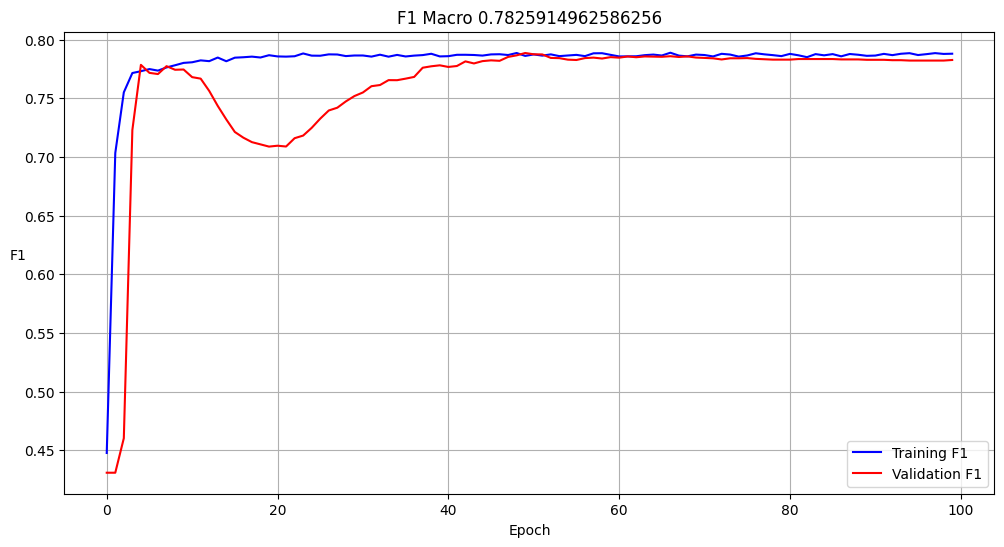

In [306]:
pos_weight = torch.tensor([counts[0] / counts[1]], dtype=torch.float32)

model = HybridMLP()
error = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, min_lr=0.00005)

col_F1_train, col_F1_val = [], []
epoch, n = 100, 1
for i in range(epoch):
  # Train
  model.train()
  y_hat_train = model(x_num_train, x_cate_trian)
  loss_BCE = error(y_hat_train, tensor_y_train)
  loss_F1 = f1_macro(y_hat_train, tensor_y_train)

  optimizer.zero_grad()
  loss_BCE.backward()
  optimizer.step()
  with torch.no_grad():
    y_hat = (y_hat_train > 0.5).float()
    loss_F1 = f1_macro(y_hat, tensor_y_train)
    col_F1_train.append(loss_F1.item())

  # Validation
  model.eval()
  with torch.no_grad():
    y_hat_val = model(x_num_val, x_cate_val)
    y_hat = (y_hat_val > 0.5).float()
    loss_BCE = error(y_hat, tensor_y_val)
    loss_F1 = f1_macro(y_hat, tensor_y_val)
    col_F1_val.append(loss_F1.item())
    scheduler.step(loss_F1)

  if i == (n-1):
    print(f"Epoch [{i+1}/{epoch}] | Loss(F1): {loss_F1:.4f} | Loss(BCE): {loss_BCE:.4f}")
    n += 1

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(epoch), col_F1_train, label="Training F1", color="blue")
plt.plot(range(epoch), col_F1_val, label="Validation F1", color="red")
plt.title(f'F1 Macro {loss_F1}')
plt.xlabel('Epoch')
plt.ylabel('F1', rotation=0)
plt.legend()

plt.show()

In [308]:
# Test
with torch.no_grad():
  y_hat_test = model(x_num_test, x_cate_test)
  y_hat_test = (y_hat_test > 0.5).float()
  loss_F1_test = f1_macro(y_hat_test, tensor_y_test)
print(f'Loss F1 : {loss_F1_test}')

torch.save(model.state_dict(), f"My_weight {loss_F1_test}.pth")

Loss F1 : 0.7825282211963114


In [309]:
# Final
with torch.no_grad():
  y_hat = model(x_num_final, x_cate_final)
  y_hat = (y_hat > 0.5).float()
  y_hat = y_hat.squeeze().numpy().astype(int)
y_hat = pd.DataFrame(y_hat)

summarize = pd.concat([id_final, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
print(summarize['loan_status'].unique())
summarize

[0 1]


,id,loan_status
0,31641,0
1,31642,1
2,31643,0
3,31644,1
4,31645,0
...,...,...
7905,39546,0
7906,39547,1
7907,39548,0
7908,39549,1
